<a href="https://colab.research.google.com/github/YagmurTaze/OCR-ICR/blob/main/2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
#pip install tensorflow==2.16.1

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## The Dataset

In [4]:
#import pandas as pd

# Excel dosyasını oku
#excel_file = '/content/train.xlsx'
#df = pd.read_excel(excel_file)

# CSV olarak kaydet (UTF-8 kodlaması ile)
#csv_file = 'train.csv'
#df.to_csv(csv_file, index=False, encoding='utf-8')

In [5]:
train = pd.read_csv('/content/train.csv')
valid = pd.read_csv('/content/validation.csv')

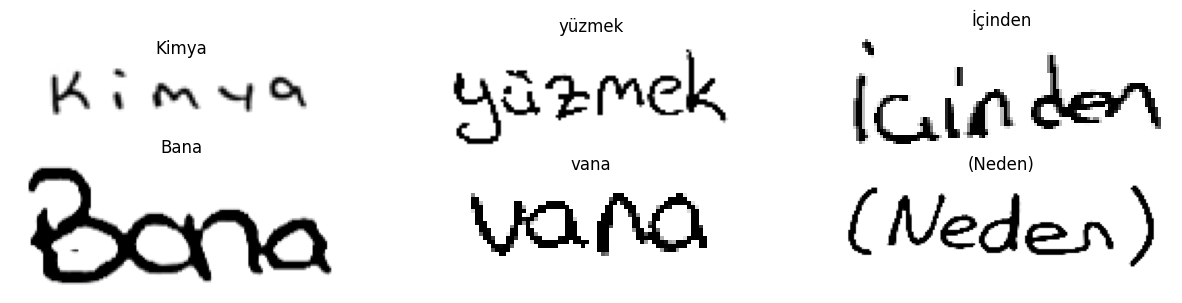

In [6]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/drive/MyDrive/Datasets/TURKISH WORDS/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [7]:
train_size = 5393
valid_size= 599

## Preprocess

In [8]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [9]:
from tqdm import tqdm

train_x = []

for i in tqdm(range(train_size)):
    img_dir = '/content/drive/MyDrive/Datasets/TURKISH WORDS/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

100%|██████████| 5393/5393 [1:10:58<00:00,  1.27it/s]


In [10]:
valid_x = []

for i in tqdm(range(valid_size)):
    img_dir = '/content/drive/MyDrive/Datasets/TURKISH WORDS/val/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

100%|██████████| 599/599 [07:52<00:00,  1.27it/s]


## part2

In [13]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [14]:
alphabets = u"ABCÇDEFGĞHIİJKLMNOÖPRSŞTUÜVYZabcçdefgğhıijklmnoöprsştuüvyz?'()\".,0123456789 "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [15]:
name = 'ABC ?'
print(name, '\n',label_to_num(name))

ABC ? 
 [ 0  1  2 75 58]


In [16]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [17]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [18]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
      '\ntrain_input_len : ', train_input_len[100])

True label :  iyi 
train_y :  [40. 56. 40. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [3.] 
train_input_len :  [62.]


## The Model

In [19]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 256, 64, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [20]:
# the ctc loss function
def ctc_lambda_func(args):
     y_pred, labels, input_length, label_length = args

     y_pred = y_pred[:, 2:, :]
     return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [21]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)


## Training

In [23]:
metrics = ['accuracy']

model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001),metrics=metrics)

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)


Epoch 1/60
43/43 [==============================] - 20s 134ms/step - loss: 33.2878 - accuracy: 0.0000e+00 - val_loss: 23.1001 - val_accuracy: 0.0000e+00
Epoch 2/60
43/43 [==============================] - 3s 81ms/step - loss: 22.6610 - accuracy: 0.0000e+00 - val_loss: 22.7214 - val_accuracy: 0.0000e+00
Epoch 3/60
43/43 [==============================] - 3s 77ms/step - loss: 22.0934 - accuracy: 0.0000e+00 - val_loss: 23.0460 - val_accuracy: 0.0000e+00
Epoch 4/60
43/43 [==============================] - 3s 75ms/step - loss: 21.6525 - accuracy: 0.0000e+00 - val_loss: 23.5049 - val_accuracy: 0.0000e+00
Epoch 5/60
43/43 [==============================] - 3s 76ms/step - loss: 21.2709 - accuracy: 0.0000e+00 - val_loss: 24.5765 - val_accuracy: 0.0000e+00
Epoch 6/60
43/43 [==============================] - 3s 77ms/step - loss: 20.5944 - accuracy: 0.0000e+00 - val_loss: 27.2335 - val_accuracy: 0.0000e+00
Epoch 7/60
43/43 [==============================] - 3s 75ms/step - loss: 19.6045 - accuracy:

## Predict

In [24]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

19/19 [==============================] - 2s 16ms/step


In [25]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 86.85%
Correct words predicted      : 69.45%


In [26]:
model_final.save("wordModel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predict

In [35]:
import cv2
import numpy as np
from keras.models import load_model, Model
from keras import backend as K
from keras.layers import Input

# Load the trained model
model = load_model("wordModel.h5", compile=False)

# Define the alphabet and other parameters
alphabets = u"ABCÇDEFGĞHIİJKLMNOÖPRSŞTUÜVYZabcçdefgğhıijklmnoöprsştuüvyz?'()\".,0123456789 "
max_str_len = 24
num_of_timestamps = 64

def preprocess(img):
    (h, w) = img.shape
    final_img = np.ones([64, 256]) * 255  # blank white image

    # crop
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]

    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret += alphabets[ch]
    return ret

# Create a new model that outputs predictions directly
input_data = Input(shape=(256, 64, 1), name='input')
y_pred = model.get_layer('softmax').output
prediction_model = Model(inputs=model.input[0], outputs=y_pred)

# Load and preprocess the new image
img_dir = '/content/word_2706.png'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
image = preprocess(image)
image = image / 255.0

# Predict
pred = prediction_model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1],
                                   greedy=True)[0][0])

print('Predicted text:', num_to_label(decoded[0]))


1/1 [==============================] - 1s 1s/step
Predicted text: "elazığ"
